In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from math import floor

from matplotlib import pyplot as plt
from tqdm import tqdm

In [17]:
if os.path.exists("./tensor_y.npy"):
    os.remove("./tensor_y.npy")
if os.path.exists("./tensor_x.npy"):
    os.remove("./tensor_x.npy")
if os.path.exists("./val_tensor_x.npy"):
    os.remove("./val_tensor_x.npy")
if os.path.exists("./val_tensor_y.npy"):
    os.remove("./val_tensor_y.npy")

# HyperParameters definition

In [18]:
epochs = 100
batch_size = 16
lr = 1e-3

alpha = 0.1

resize_height = 256
resize_width = 256

ratio = 4
train_val_split_perc = 0.9
val_test_split_perc = 0.5

# Dataset Classes definition

In [19]:
class Generator(keras.utils.Sequence):
    def __init__(self, x: list, y: list):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        return x, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()

# Dataset Preprocessing

In [20]:
def preprocessing(path, ratio, resize_height, resize_width):
    y = tf.keras.utils.load_img(path)
    y = tf.keras.utils.img_to_array(y)
    y = tf.image.resize(y,
                        [resize_height, resize_width],
                        'bicubic',
                        antialias=True,
                        )
    height, width, _ = y.shape
    x = tf.image.resize(y,
                        [height // ratio, width // ratio],
                        'bicubic',
                        antialias=True,
                        )
    x = x / 255.0
    y = y / 255.0
    return x, y

In [21]:
img_paths = []
val_img_paths = []
for dirname, _, filenames in os.walk('../input/div2k-dataset/DIV2K_train_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('../input/div2k-dataset/DIV2K_valid_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
print('Dataset dimension: ', len(img_paths))

val_img_paths = img_paths[floor(len(img_paths) * train_val_split_perc):]
img_paths = img_paths[:floor(len(img_paths) * train_val_split_perc)]
print('Training: ', len(img_paths))

Dataset dimension:  900
Training:  810


In [22]:
if not (os.path.exists('./tensor_x.npy')) or not (os.path.exists('./tensor_y.npy')):

    img_lr = []
    img_hr = []

    for i in tqdm(range(len(img_paths))):
        x, y = preprocessing(img_paths[i], ratio, resize_height, resize_width)
        img_lr.append(x)
        img_hr.append(y)
    
    tensor_x = tf.convert_to_tensor(img_lr).numpy()
    tensor_y = tf.convert_to_tensor(img_hr).numpy()
    tensor_x.shape

    np.save('./tensor_x.npy', tensor_x)
    np.save('./tensor_y.npy', tensor_y)
    img_lr = tensor_x
    img_hr = tensor_y
else:
    img_lr = np.load('./tensor_x.npy')
    img_hr = np.load('./tensor_y.npy')

    

100%|██████████| 810/810 [02:19<00:00,  5.81it/s]


In [23]:
if not (os.path.exists('./val_tensor_x.npy')) or not (os.path.exists('./val_tensor_y.npy')):

    val_img_lr = []
    val_img_hr = []

    for i in tqdm(range(len(val_img_paths))):
        x, y = preprocessing(val_img_paths[i], ratio, resize_height * 2, resize_width * 2)
        val_img_lr.append(x)
        val_img_hr.append(y)
    
    val_tensor_x = tf.convert_to_tensor(val_img_lr).numpy()
    val_tensor_y = tf.convert_to_tensor(val_img_hr).numpy()

    np.save('./val_tensor_x.npy', val_tensor_x)
    np.save('./val_tensor_y.npy', val_tensor_y)
    val_img_lr = tensor_x
    val_img_hr = tensor_y
else:
    val_img_lr = np.load('./val_tensor_x.npy')
    val_img_hr = np.load('./val_tensor_y.npy')

100%|██████████| 90/90 [00:20<00:00,  4.50it/s]


In [24]:
train_generator = Generator(img_lr, img_hr)
val_generator = Generator(val_img_lr[:floor(val_img_lr.shape[0] * val_test_split_perc)], val_img_hr[:floor(val_img_lr.shape[0] * val_test_split_perc)])
test_generator = Generator(val_img_lr[floor(val_img_lr.shape[0] * val_test_split_perc):], val_img_hr[floor(val_img_lr.shape[0] * val_test_split_perc):])

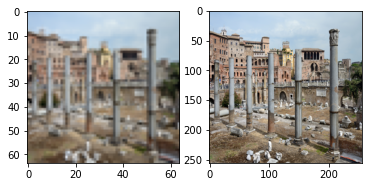

In [25]:
x, y = train_generator[0]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)

In [26]:
train_dataset = tf.data.Dataset.from_generator(train_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)

train_dataset = train_dataset.prefetch(4)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_generator) + 1, reshuffle_each_iteration=True)

In [27]:
val_dataset = tf.data.Dataset.from_generator(val_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
val_dataset = val_dataset.prefetch(4)
val_dataset = val_dataset.cache()

In [28]:
test_dataset = tf.data.Dataset.from_generator(test_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
test_dataset = test_dataset.prefetch(4)
test_dataset = test_dataset.cache()

# Custom Loss function definition

In [29]:
@tf.function
def MeanGradientError(targets, outputs):
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -2], [0, 0, 0], [1, 2, 1]], dtype = outputs.dtype), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = outputs.dtype), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

    # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

    # square
    output_gradients = tf.math.add(output_gradient_x, output_gradient_y)
    target_gradients = tf.math.add(target_gradient_x, target_gradient_y)

    # compute mean gradient error
    mge = tf.keras.metrics.mean_absolute_error(output_gradients, target_gradients)

    return mge

In [30]:
@tf.function
def overall_loss_func(y_true, y_pred):
    mae_loss = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mge_loss = MeanGradientError(y_true, y_pred)
    return mae_loss + alpha * mge_loss

# Model implementation

In [31]:
def SR_model(upscale_factor=4, channels=3):
    conv_args = {
        "activation": "relu",
        "padding": "same",
    }
    inputs = layers.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


In [32]:
net = SR_model()
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 48)    13872     
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 3)     0         
Total params: 74,128
Trainable params: 74,128
Non-trainable params: 0
_________________________________________________________

In [33]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=overall_loss_func, metrics=['mae', MeanGradientError])

# Training step

In [34]:
history = net.fit(
        x = train_dataset,
        epochs = epochs,
        verbose = 1,
        validation_data = val_dataset
)

Epoch 1/100
51/51 [==============================] - 11s 41ms/step - loss: 0.7833 - mae: 0.3064 - MeanGradientError: 4.7696 - val_loss: 0.6760 - val_mae: 0.2375 - val_MeanGradientError: 4.3849
Epoch 2/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5984 - mae: 0.1858 - MeanGradientError: 4.1255 - val_loss: 0.5357 - val_mae: 0.1333 - val_MeanGradientError: 4.0235
Epoch 3/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4987 - mae: 0.1094 - MeanGradientError: 3.8926 - val_loss: 0.4684 - val_mae: 0.0829 - val_MeanGradientError: 3.8552
Epoch 4/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4528 - mae: 0.0801 - MeanGradientError: 3.7275 - val_loss: 0.4364 - val_mae: 0.0719 - val_MeanGradientError: 3.6455
Epoch 5/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4277 - mae: 0.0693 - MeanGradientError: 3.5842 - val_loss: 0.4194 - val_mae: 0.0659 - val_MeanGradientError: 3.5351
Epoch 6/100
51/51 [====================

# Visualization of training curves

dict_keys(['loss', 'mae', 'MeanGradientError', 'val_loss', 'val_mae', 'val_MeanGradientError'])


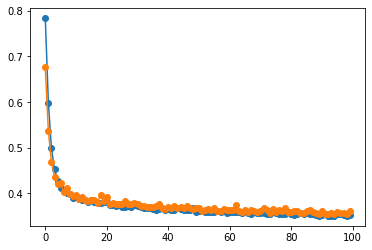

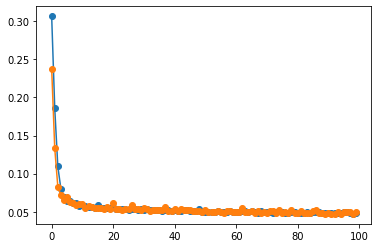

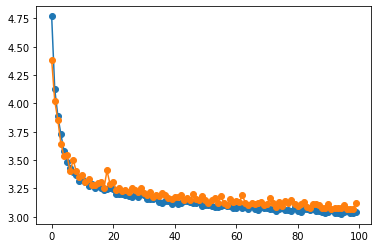

In [35]:
print(history.history.keys())
plt.figure()
plt.plot(history.history['loss'], label='train', marker='o')
plt.plot(history.history['val_loss'], label='val', marker='o')

plt.figure()
plt.plot(history.history['mae'], label='train', marker='o')
plt.plot(history.history['val_mae'], label='val', marker='o')

plt.figure()
plt.plot(history.history['MeanGradientError'], label='train', marker='o')
plt.plot(history.history['val_MeanGradientError'], label='val', marker='o')

# Testing

In [36]:
outputs = net.predict(test_dataset)

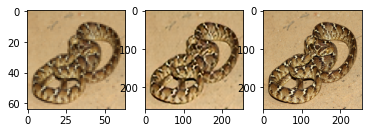

In [37]:
x, y = test_generator[0]
plt.figure()
plt.subplot(1,3,1)
plt.imshow(x)
plt.subplot(1,3,2)
plt.imshow(outputs[0])
plt.subplot(1,3,3)
plt.imshow(y)